In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *


Train with GPU support.


# 0. Describe Experiment

- Modelling interactions -> is it possible to learn the proper functions:

h(x4|x1,x2,x3)=SI(1)+CS(x1,x2)+LS(X3)

# 1. Experiments and Paths

In [2]:
experiment_name = "modelling_interactions4"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Created new configuration file at /home/bule/TramDag/dev_experiment_logs/modelling_interactions4/configuration.json


# 2.  Data

In [3]:
def f1(x1, x2):
    return np.sin(np.pi * x1) * np.cos(np.pi * x2)


def dgp_continuous_interactions(n_obs=10_000, seed=42):
    np.random.seed(seed)

    # Independent variables
    x1 = np.random.uniform(0, 2, size=n_obs)
    x2 = np.random.uniform(0, 2, size=n_obs)
    x3 = np.random.uniform(0, 2, size=n_obs)

    
    x4 = f1(x1, x2) + 1.5 * x3

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4})
    return df


EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp_continuous_interactions()

    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")



data_type= {'x1':'cont','x2':'cont','x3':'cont','x4':'cont'} # cont:continous, ord:ordinal, oher:everything else than images


# write the data types to configuration file
write_data_type_to_configuration(data_type, CONF_DICT_PATH)


         x1        x2        x3        x4
0  0.749080  0.747282  1.459997  1.692853
1  1.901429  0.665824  0.369024  0.705210
2  1.463988  0.352308  0.693279  0.595261
3  1.197317  1.214533  1.326561  2.443761
4  0.312037  0.953248  0.964179  0.624550
Configuration updated successfully.


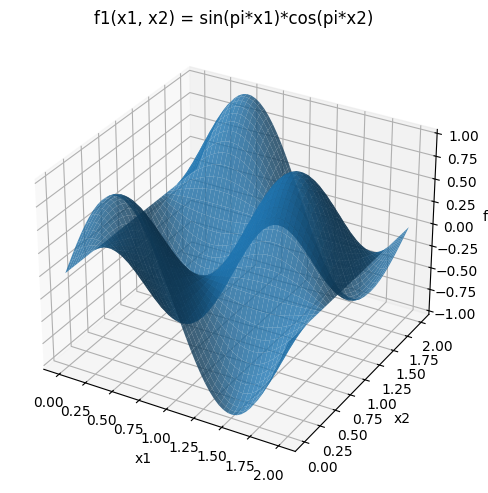

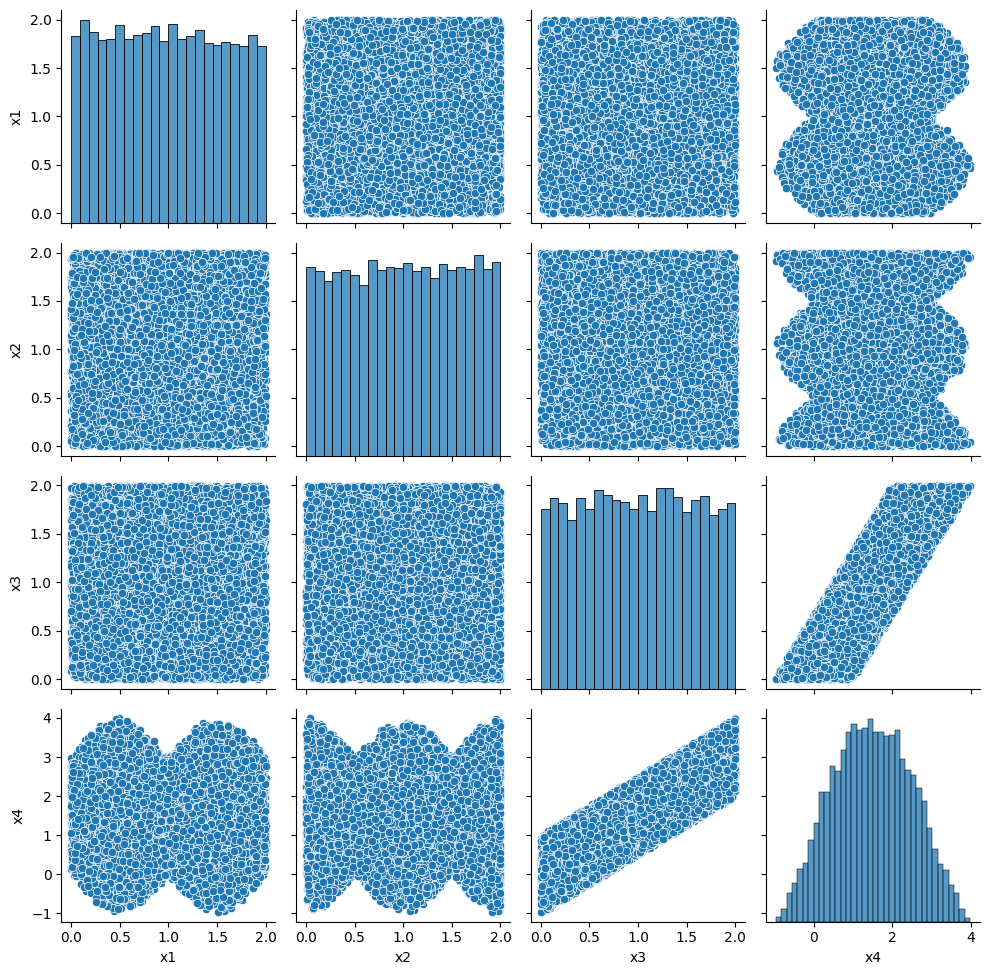

In [4]:



# Visualize the 3 interaction functions
fig = plt.figure(figsize=(18, 5))

# f1(x1, x2)
ax = fig.add_subplot(131, projection='3d')
x = np.linspace(0, 2, 50)
y = np.linspace(0, 2, 50)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f1(x1, x2) = sin(pi*x1)*cos(pi*x2)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f1")

plt.tight_layout()
plt.show()


sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
def normalize_with_quantiles(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


In [6]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

No matrix found. Please fill out the DAG and click 'Generate'.


# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> still there are default networs which one can use

In [8]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************


In [9]:
write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals)

Configuration updated successfully.


/home/bule/TramDag/utils/graph.py:589: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nodes_dict[node]['min']=min_vals[i].tolist()
/home/bule/TramDag/utils/graph.py:590: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nodes_dict[node]['max']=max_vals[i].tolist()


# 5. Train models

- set epochs and batchsize

In [10]:
train_list=['x1','x2','x3','x4'] #<-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 1000# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.1
use_scheduler =  True

In [ ]:
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
# For each NODE 
target_nodes = configuration_dict['nodes']

for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    MODEL_PATH, LAST_MODEL_PATH, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)

    ########################## 2. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=True).to(device)

    # order the terms in the correct order for preprocessing dataloader correctly
    _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes)
    
    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, target_nodes, train_df, val_df, batch_size=batch_size, verbose=True)

    ########################## 4. Load Model & History ######################
    if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(MODEL_PATH))

        with open(TRAIN_HIST_PATH, 'r') as f:
            train_loss_hist = json.load(f)
        with open(VAL_HIST_PATH, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
        print(f"Continuing training from epoch {start_epoch}...")
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist, val_loss_hist = [], []
        start_epoch = 0
        best_val_loss = float('inf')

    # Skip if already trained
    if start_epoch >= epochs:
        print(f"Node {node} already trained for {epochs} epochs. Skipping.")
        continue

    ########################## 5. Optimizer & Scheduler ######################.
    
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=1e-3, total_steps=epochs * len(train_loader),pct_start=0.1, anneal_strategy="cos"       # pick your sweet-spot
    else:
        scheduler = None

    ########################## 6. Min/Max Tensor #############################
    min_vals = torch.tensor(target_nodes[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(target_nodes[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 7. Training Loop ##############################

    
    train_val_loop(
                    start_epoch,
                    epochs,
                    tram_model,
                    train_loader,
                    val_loader,
                    train_loss_hist,
                    val_loss_hist,
                    best_val_loss,
                    device,
                    optimizer,
                    use_scheduler,
                    scheduler,
                    min_max,
                    NODE_DIR,
                    ordered_transformation_terms_in_h,
                    save_linear_shifts=True,
                    verbose=1
                 )


----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Source → SimpleIntercept only
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 500...


Epoch 501/800 | Train Loss: 0.6823 | Val Loss: 0.6890
  [Train: 0.47s | Val: 0.20s | Save: 0.00s | Total: 0.67s]
Epoch 502/800 | Train Loss: 0.6806 | Val Loss: 0.6909
  [Train: 0.41s | Val: 0.19s | Save: 0.00s | Total: 0.60s]
Epoch 503/800 | Train Loss: 0.6812 | Val Loss: 0.6894
  [Train: 0.42s | Val: 0.22s | Save: 0.00s | Total: 0.64s]
Epoch 504/800 | Train Loss: 0.6810 | Val Loss: 0.6903
  [Train: 0.44s | Val: 0.20s | Save: 0.01s | Total: 0.65s]
Epoch 505/800 | Train Loss: 0.6811 | Val Loss: 0.6890
  [Train: 0.46s | Val: 0.23s | Save: 0.00s | Total: 0.69s]
Epoch 506/800 | Train Loss: 0.6813 | Val Loss: 0.6906
  [Train: 0.44s | Val: 0.22s | Save: 0.01s | Total: 0.67s]
Epoch 507/800 | Train Loss: 0.6816 | Val Loss: 0.6903
  [Train: 0.47s | Val: 0.23s | Save: 0.00s | Total: 0.71s]
Epoch 508/800 | Train Loss: 0.6820 | Val Loss: 0.6891
  [Train: 0.42s | Val: 0.19s | Save: 0.01s | Total: 0.61s]
Epoch 509/800 | Train Loss: 0.6813 | Val Loss: 0.6916
  [Train: 0.48s | Val: 0.22s | Save: 0.01s

# 6 Inspect Training

## 6.1 Loss vs epochs

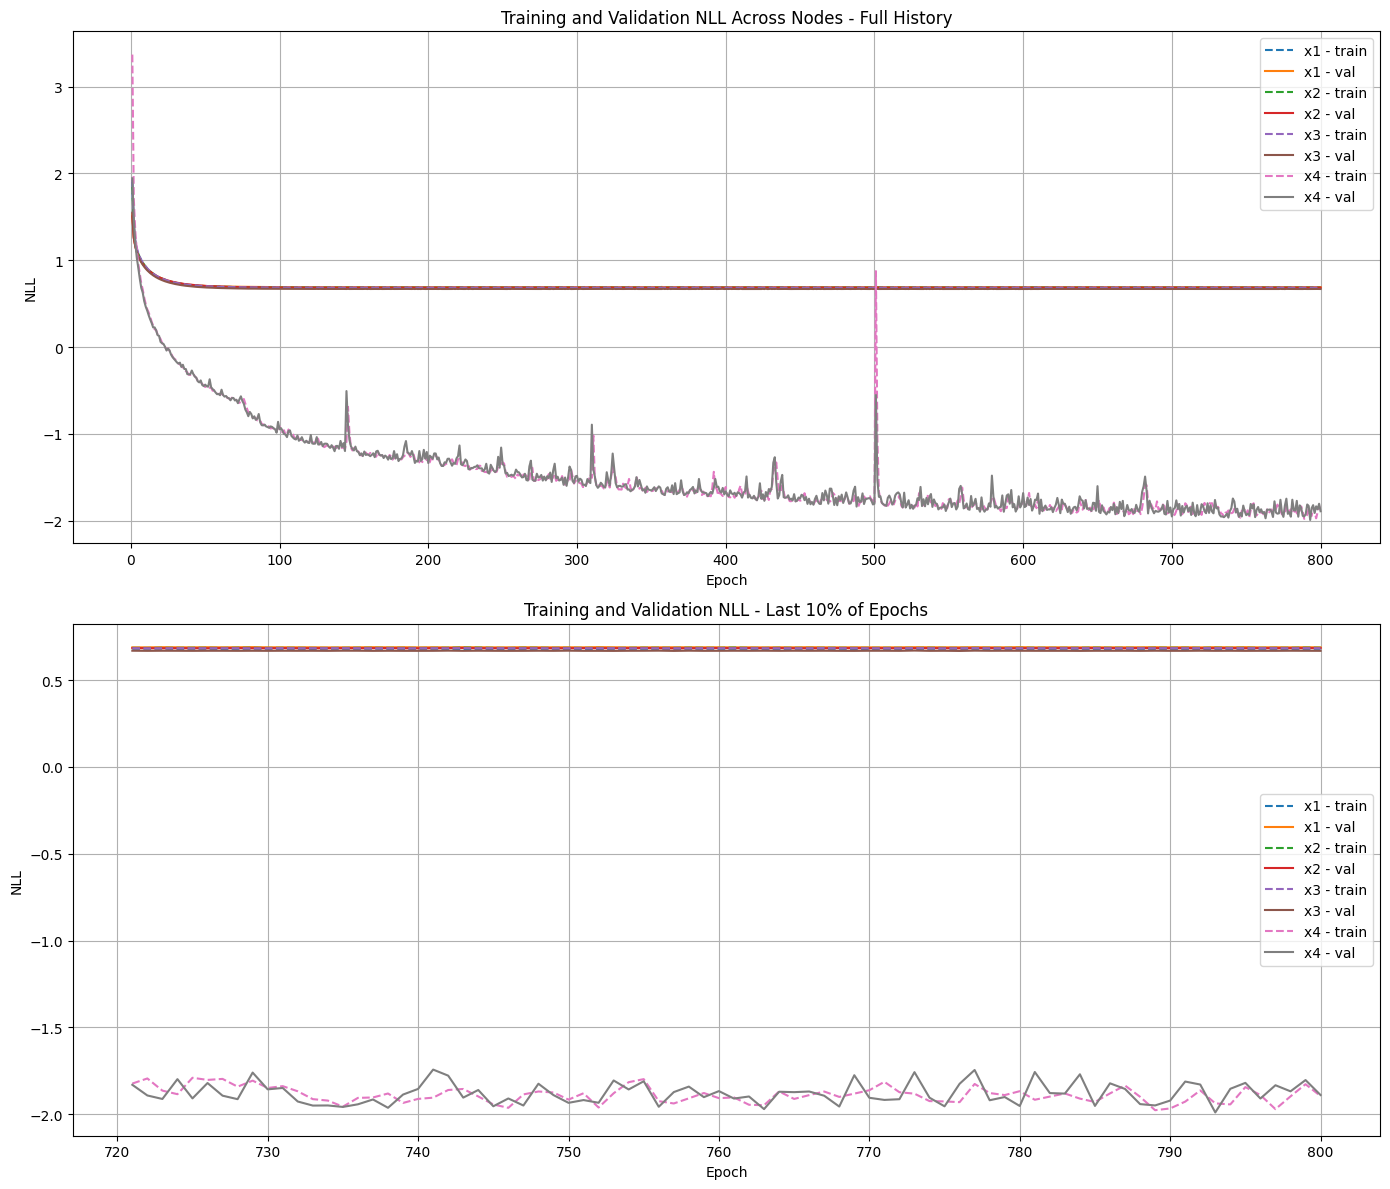

In [ ]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


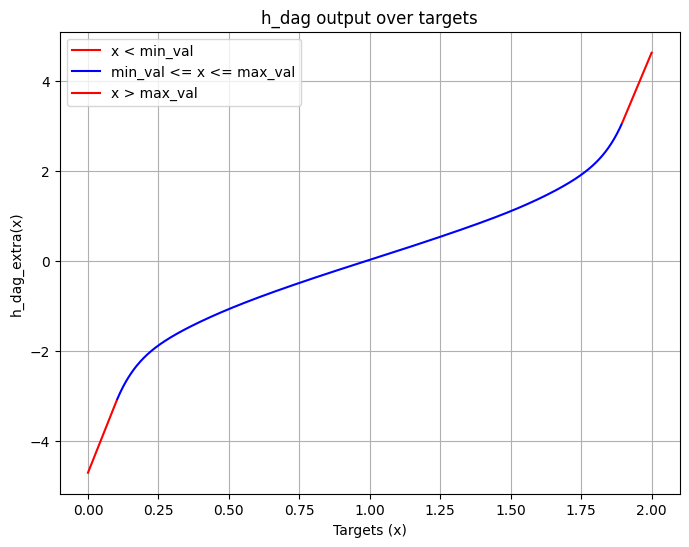


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--


h() for  x2:   0%|          | 0/1000 [00:00<?, ?it/s]


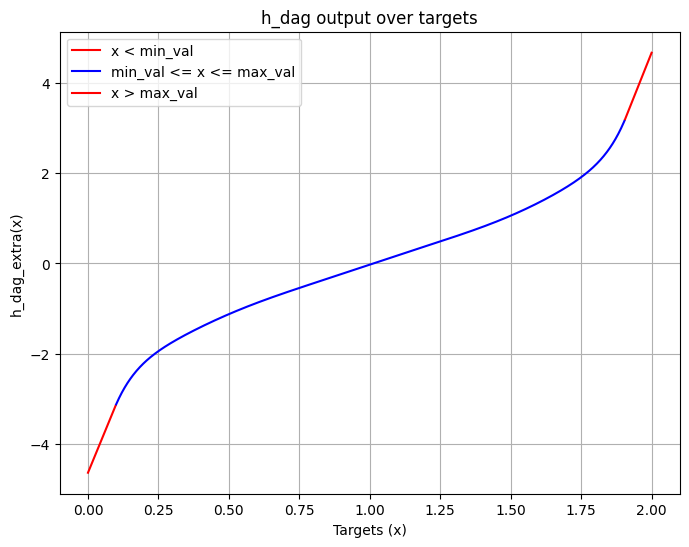


----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--


h() for  x3:   0%|          | 0/1000 [00:00<?, ?it/s]


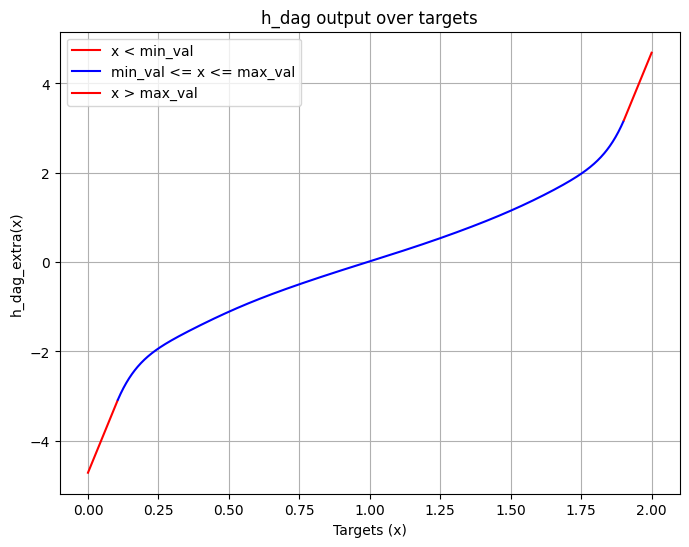


----*----------*-------------*--------Inspect TRAFO Node: x4 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [ ]:
show_hdag_for_source_nodes(target_nodes,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=2) # TODO for other nodes funciton


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


Val loader (x1): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


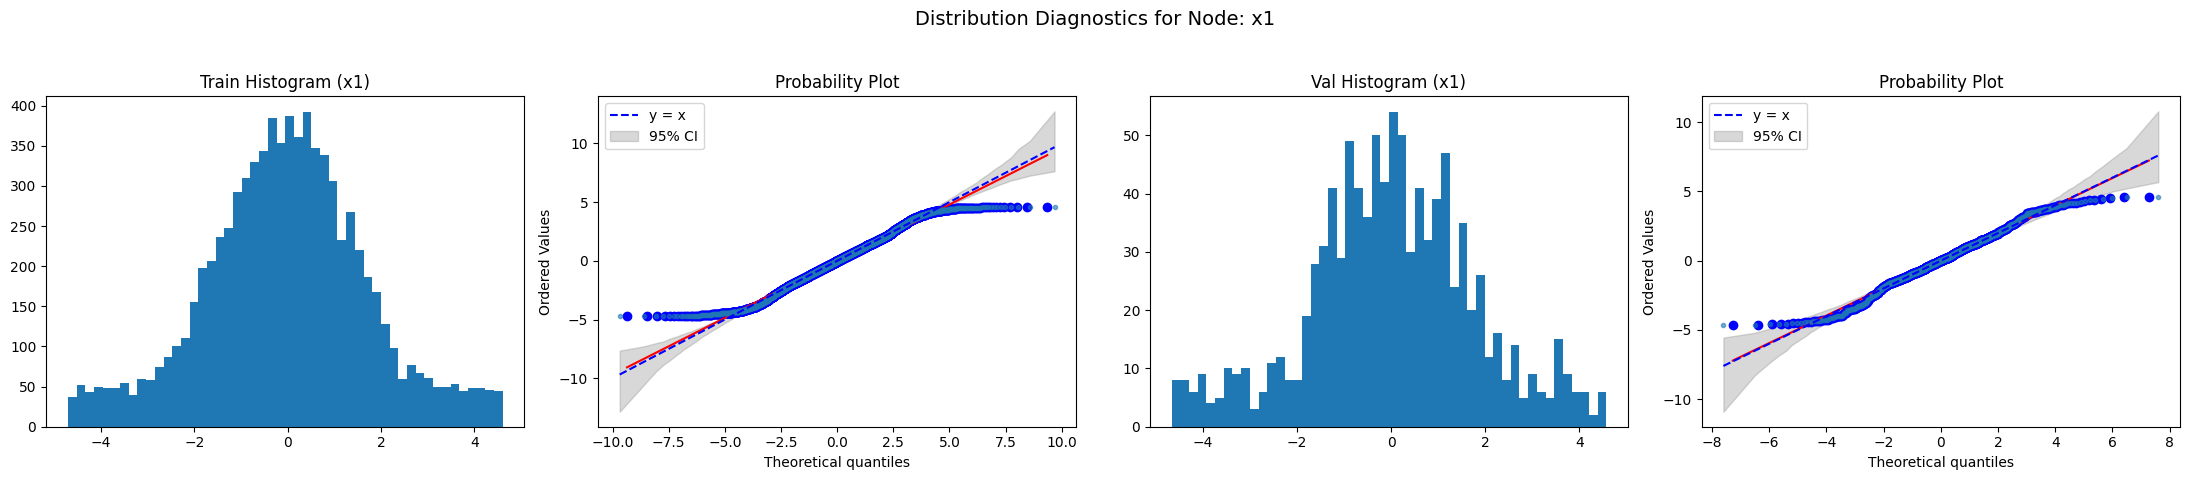


----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


Val loader (x2): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


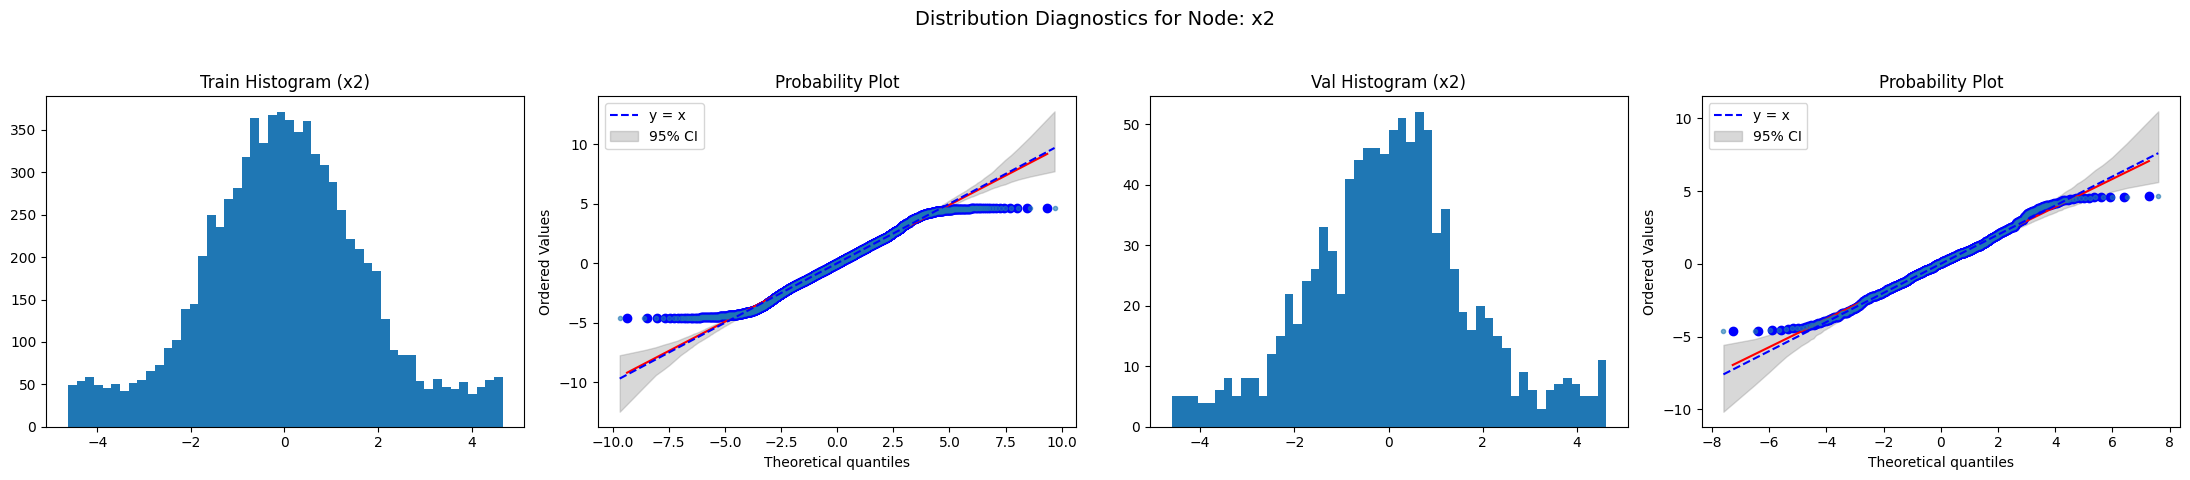


----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


Val loader (x3): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


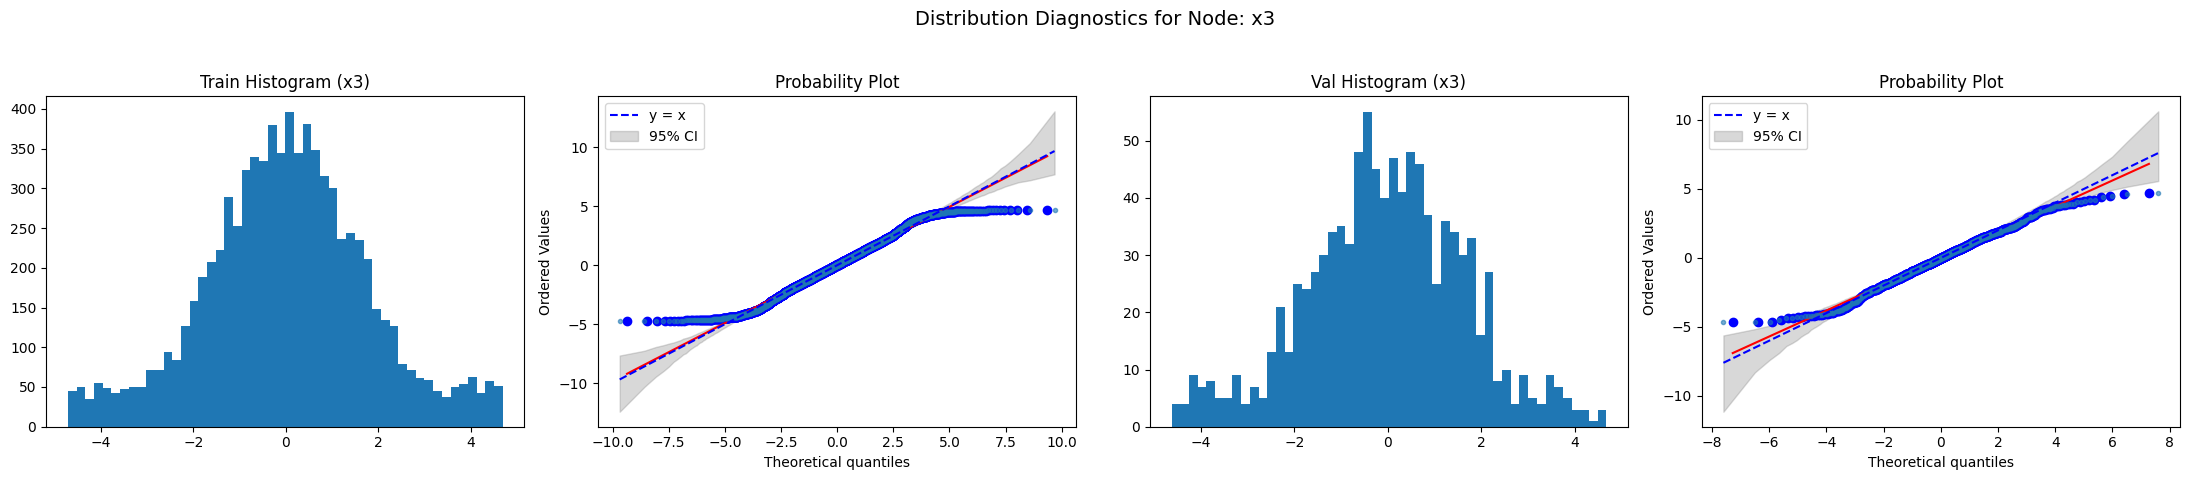


----*----------*-------------*--------h(data) should be standard logistic: x4 ------------*-----------------*-------------------*--


Val loader (x4): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


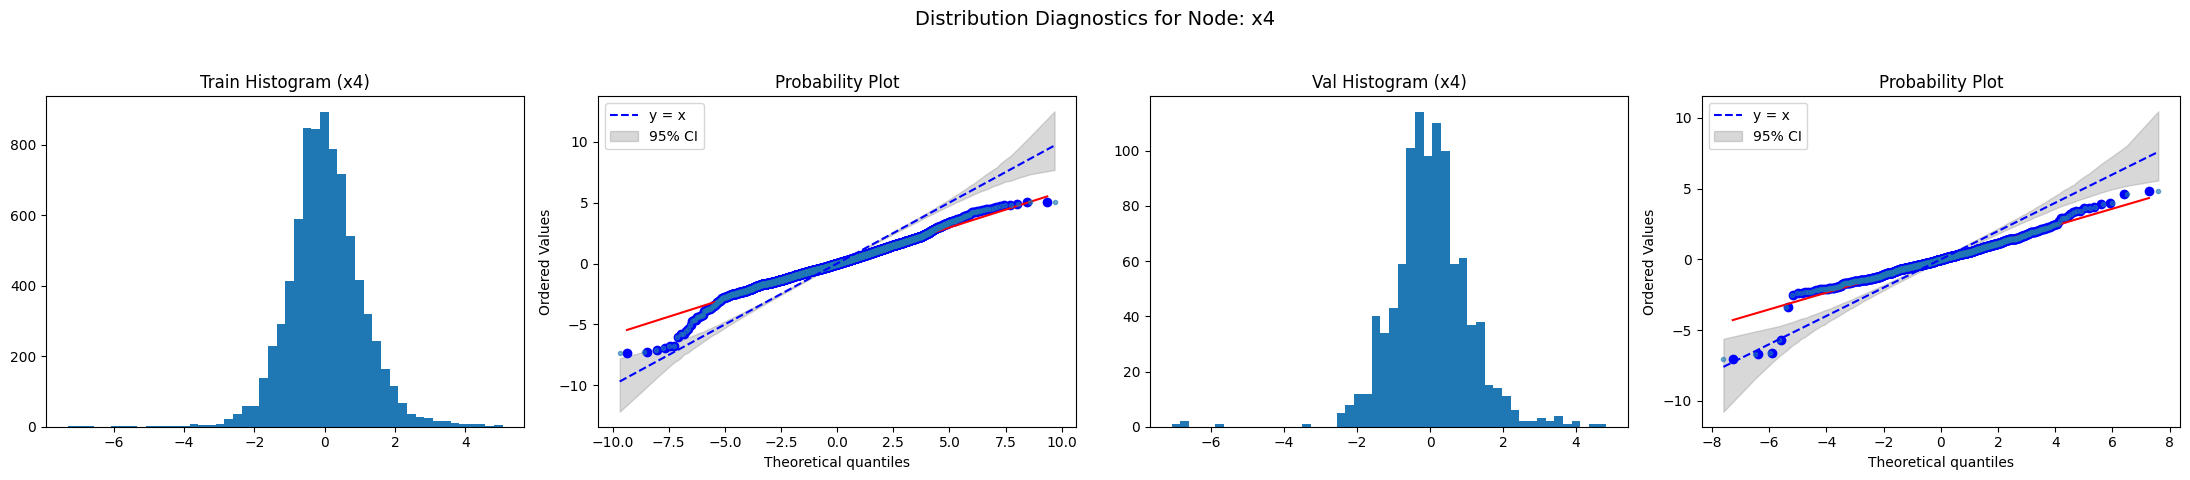

In [ ]:
inspect_trafo_standart_logistic(target_nodes,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficient estimates


---- check CS of x1 ----
Node type: source — skipping.

---- check CS of x2 ----
Node type: source — skipping.

---- check CS of x3 ----
Node type: source — skipping.

---- check CS of x4 ----

Module 0: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=False)
)
  expects input shape = (batch_size, 2)


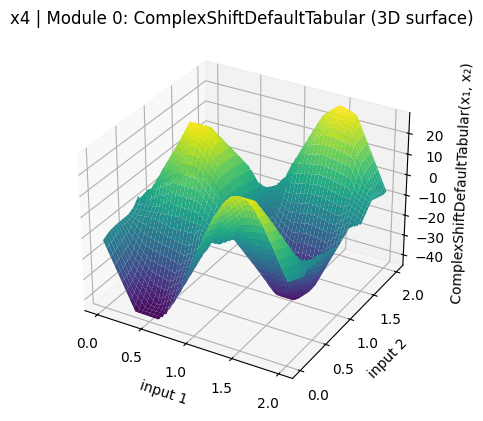


Module 1: LinearShift
LinearShift(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
  LinearShift weights:
tensor([[-53.2644]], device='cuda:0')


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enable 3D plotting

# --- Your existing setup ---
verbose    = False
batch_size = 4112
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this x is only for overlaying your target curve in 2D plots
x1d = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (1000, 1)
def f(x):
    return 0.75 * np.arctan(5 * (x + 0.12))

for node in target_nodes:
    print(f"\n---- check CS of {node} ----")
    if target_nodes[node]['node_type'] == 'source':
        print("Node type: source — skipping.")
        continue

    # load your model
    NODE_DIR   = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=verbose).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()


    for i, module in enumerate(tram_model.nn_shift):
        name = module.__class__.__name__
        print(f"\nModule {i}: {name}")
        print(module)

        if name == 'LinearShift':
            print("  LinearShift weights:")
            print(module.fc.weight.data)
            continue

        # read wanted input dims
        in_feats = module.fc1.in_features
        print(f"  expects input shape = (batch_size, {in_feats})")

        # 2-input case → 3D surface plot
        if in_feats == 2:
            N = 100
            a = torch.linspace(-0, 2, steps=N, device=device)
            b = torch.linspace(-0, 2, steps=N, device=device)
            A, B = torch.meshgrid(a, b, indexing='ij')       # both (N, N)
            grid = torch.stack([A, B], dim=-1).view(-1, 2)   # (N*N, 2)

            with torch.no_grad():
                Y = module(grid).view(N, N).cpu().numpy()    # back to (N, N)

            A_np = A.cpu().numpy()
            B_np = B.cpu().numpy()

            fig = plt.figure()
            ax  = fig.add_subplot(111, projection='3d')
            ax.plot_surface(A_np, B_np, Y, cmap='viridis', edgecolor='none')
            ax.set_xlabel('input 1')
            ax.set_ylabel('input 2')
            ax.set_zlabel(f'{name}(x₁, x₂)')
            ax.set_title(f"{node} | Module {i}: {name} (3D surface)")
            plt.show()

        # 1-input case → 2D scatter
        else:
            N = 1000
            lin = torch.linspace(-1, 1, steps=N, device=device)
            dummy = lin.unsqueeze(1).repeat(1, in_feats)      # (N, in_feats)

            with torch.no_grad():
                y = module(dummy).squeeze().cpu().numpy()

            plt.figure()
            plt.scatter(dummy[:, 0].cpu().numpy(), y, s=5, label=f"{name} output")
            # overlay target
            plt.scatter(x1d.cpu().numpy(), -f(x1d.cpu().numpy()), c="red", s=5, label="target")
            plt.xlabel("input value")
            plt.ylabel("output value")
            plt.title(f"{node} | Module {i}: {name} (2D)")
            plt.legend()
            plt.show()


# 7. Sample from Graph

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            n= 100,
                            batch_size = 2,
                            delete_all_previously_sampled=True,
                            verbose=True)     

Directory does not exist: /home/bule/TramDag/dev_experiment_logs/modelling_interactions3/x1/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/modelling_interactions3/x2/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/modelling_interactions3/x3/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/modelling_interactions3/x4/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/modelling_interactions3/x1/sampling
-- sampled latents
Source → SimpleIntercept only
-- loaded modelweights


h() for samples in  x1: 100%|██████████| 50/50 [00:00<00:00, 1712.94it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 342.24it/s]



----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/modelling_interactions3/x2/sampling
-- sampled latents
Source → SimpleIntercept only
-- loaded modelweights


h() for samples in  x2: 100%|██████████| 50/50 [00:00<00:00, 4575.04it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:28<00:00, 349.24it/s]



----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/modelling_interactions3/x3/sampling
-- sampled latents
Source → SimpleIntercept only
-- loaded modelweights


h() for samples in  x3: 100%|██████████| 50/50 [00:00<00:00, 4693.82it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:28<00:00, 345.39it/s]
/home/bule/TramDag/utils/sampling_tram_data.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list.append(torch.tensor(tensor))  # ensure tensor type



----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/modelling_interactions3/x4/sampling
-- sampled latents
Constructed TRAM model: TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=2, out_features=64, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=64, out_features=128, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=128, out_features=64, bias=True)
      (relu3): ReLU()
      (fc4): Linear(in_features=64, out_features=1, bias=False)
    )
    (1): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
-- loaded modelweights


h() for samples in  x4: 100%|██████████| 50/50 [00:00<00:00, 1278.78it/s]


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 343.44it/s]


## 7.3 Inspect Sampling

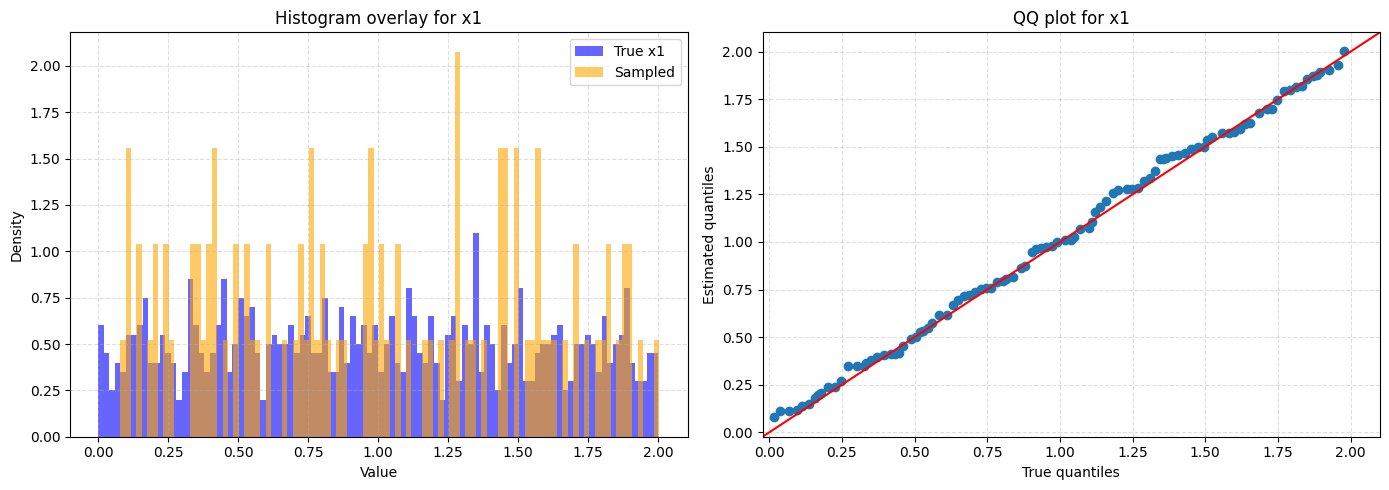

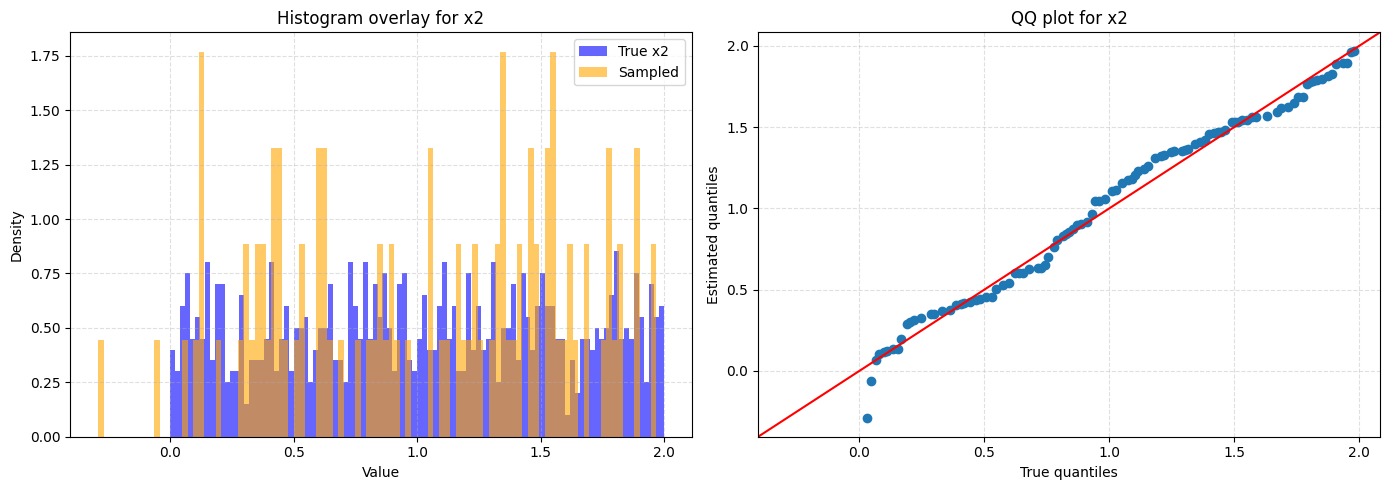

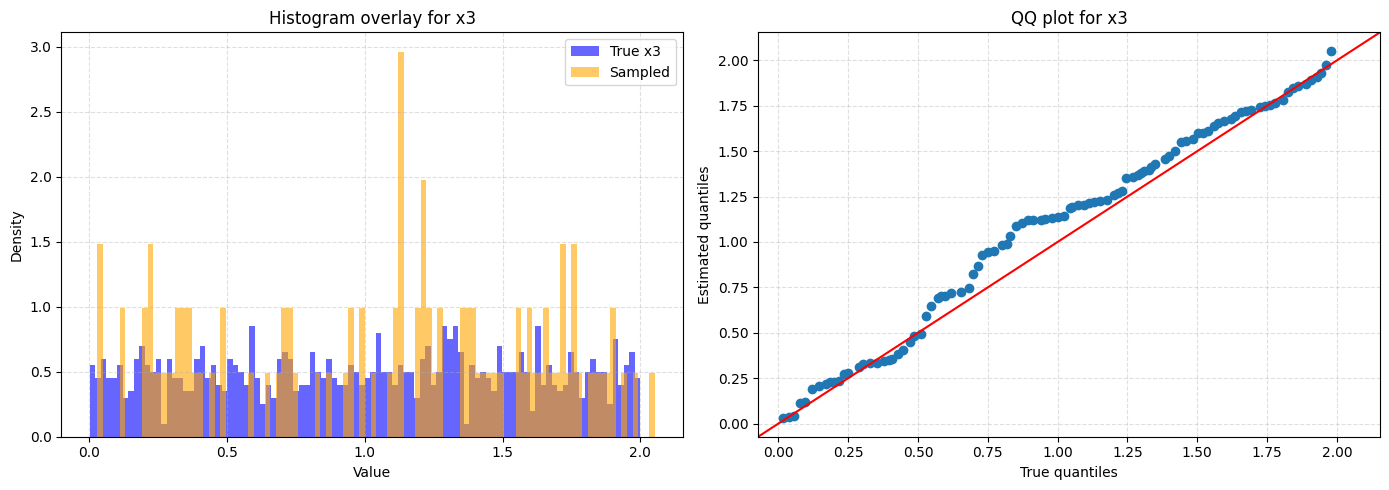

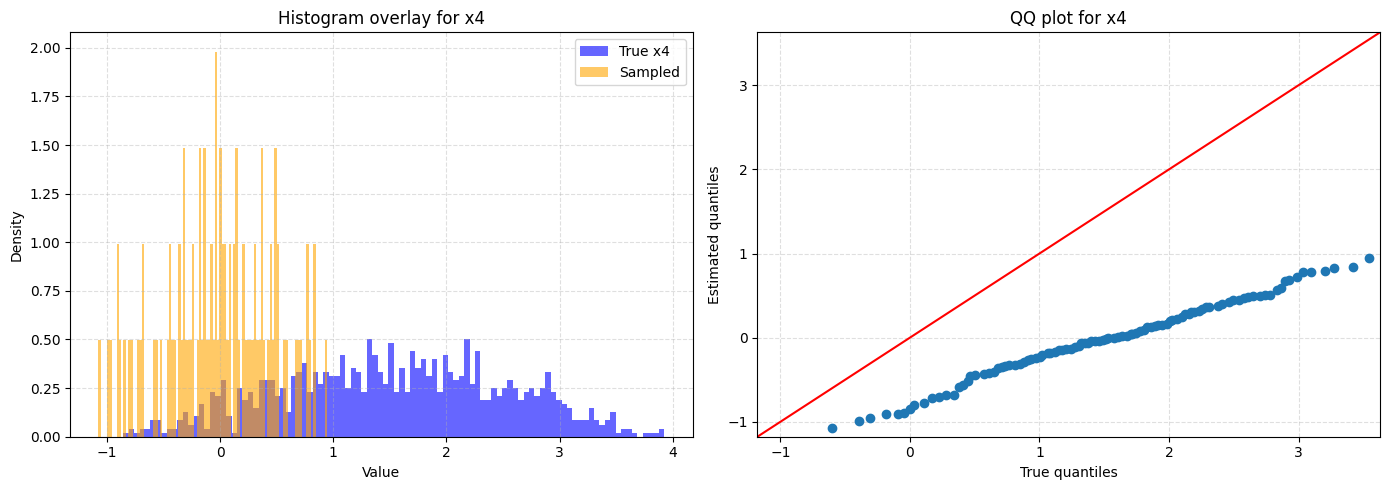

In [ ]:
show_samples_vs_true(test_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')